In [1]:
#!/usr/bin/env python 
# coding:utf-8

import time, argparse, gc, os
import sys
import tqdm
import json
import gc
import numpy as np
import pandas as pd

from rdkit import Chem

import sklearn
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, SubsetRandomSampler


# custom functions
sys.path.append('/scratch-shared/akshai/Publication/supp_scripts/CNN_paper_codes/')
from feature import *
import SCFPfunctions as Mf
sys.path.append('/scratch-shared/akshai/Publication/supp_scripts/')
import supp_utils as su

# set gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()

(device(type='cuda'), True)

In [2]:
# To remove rdkit warning
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [3]:
parameter_filename = "parameters.json" 

In [4]:
parameter_file = open(parameter_filename)
parameters = json.load(parameter_file)
parameter_file.close()

# User inputs
input_file = parameters["input_file"] # input file

trial = parameters["trial"] # setting False saves the output files else not saved

k_fold_value = int(parameters["k_fold_value"]) # Number of folds

test_set_percentage = float(parameters["test_set_percentage"])

# Removing data with lower distribution
enable_label_cutoff = parameters["label_cutoff"]["enable_label_cutoff"]
lower_label_count_cutoff = int(parameters["label_cutoff"]["lower_label_count_cutoff"])
upper_label_count_cutoff = int(parameters["label_cutoff"]["upper_label_count_cutoff"])

lensize = int(parameters["sequence_length_cutoff"]["lensize"]) # feature vector size
atomsize = int(parameters["sequence_length_cutoff"]["atomsize"]) # max length of molecule


learning_rate = float(parameters["network_parameters"]["learning_rate"])
epochs = int(parameters["network_parameters"]["epochs"])
batchsize = int(parameters["network_parameters"]["batchsize"])
enable_class_weight = parameters["network_parameters"]["enable_class_weight"]

# k = window size
# s = strides
# f = number of filters

# first convolution
k1 = int(parameters["conv1"]["k1"])
s1 = int(parameters["conv1"]["s1"])
f1 = int(parameters["conv1"]["f1"])

# max pooling 1 
k2 = int(parameters["pool1"]["k2"])
s2 = int(parameters["pool1"]["s2"])

# second convolution
k3 = int(parameters["conv2"]["k3"])
s3 = int(parameters["conv2"]["s3"])
f3 = int(parameters["conv2"]["f3"])

# max pooling 2
k4 = int(parameters["pool2"]["k4"])
s4 = int(parameters["pool2"]["s4"])

# number of hidden layers
n_hid = int(parameters["fc_layer_parameters"]["n_hid"])
n_out = int(parameters["fc_layer_parameters"]["n_out"])

os.system("mkdir run_files")
if not trial:
    network_parameter_output = open("run_files/network_parameters.txt","w",1)
    for parameter in parameters:
        network_parameter_output.write(str(parameter) + " = " + str(parameters[parameter]) + "\n")

In [5]:
class Net(nn.Module):
    def __init__(self, atomsize, lensize, k1, s1, f1, k2, s2, k3, 
                 s3, f3, k4, s4, n_hid, n_out):
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, f1, (k1,lensize),padding=(k1//2,0),stride=(s1,s1))
        self.bn1 = nn.BatchNorm2d(f1)
        self.leakyr = nn.LeakyReLU()
        self.pool1 = nn.AvgPool2d((k2,1),stride=(s2,s2),padding=(k2//2,0))
        self.conv2 = nn.Conv2d(f1,f3,(k3,1),stride=(s3,s3),padding=(k3//2,0))
        self.bn2 = nn.BatchNorm2d(f3)
        self.pool2 = nn.AvgPool2d((k4,1),stride=(s4,s4),padding=(k4//2,0))
        self.maxpool = nn.MaxPool2d(kernel_size=2),
        self.fc1 = nn.Linear(f3, n_hid)
        self.fc2 = nn.Linear(n_hid, n_out)
        self.bn3 = nn.BatchNorm1d(n_hid)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.pool1(self.leakyr(self.bn1(self.conv1(x))))
        x = self.pool2(self.leakyr(self.bn2(self.conv2(x))))
        x = F.max_pool2d(x,kernel_size=x.size()[2:])
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.dropout(self.leakyr(x))
        x = self.fc2(x)
        return x

In [6]:
smiles_label,label_count = su.get_data_within_cutoff(input_file,lower_label_count_cutoff,upper_label_count_cutoff)

487/4982 data points obtained


In [7]:
train_valid_df,test_df,_ = su.split_data_with_label(smiles_label,train_percentage=1-test_set_percentage,valid_percentage=test_set_percentage)

Best model
LOSS train: 0.18042765451329096  val: 0.6233808398246765 	ACCU train: 0.9488636363636364  val: 0.6066176470588236
Final model
LOSS train: 0.12558900405253684  val: 1.1322115063667297 	ACCU train: 0.968952922077922  val: 0.5579044117647058


/home/jovyan/anaconda3/envs/molpmofit/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/anaconda3/envs/molpmofit/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/anaconda3/envs/molpmofit/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Best model
LOSS train: 0.5570194359336581  val: 0.7209844887256622 	ACCU train: 0.7215909090909091  val: 0.45588235294117646
Final model
LOSS train: 0.11561535405261177  val: 0.8915322422981262 	ACCU train: 0.9665178571428571  val: 0.5615808823529411


/home/jovyan/anaconda3/envs/molpmofit/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/anaconda3/envs/molpmofit/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jovyan/anaconda3/envs/molpmofit/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Best model
LOSS train: 0.5665378740855626  val: 0.7048227787017822 	ACCU train: 0.7179383116883117  val: 0.49724264705882354
Final model
LOSS train: 0.19749469948666437  val: 0.861945629119873 	ACCU train: 0.9364853896103896  val: 0.6360294117647058


Best model
LOSS train: 0.19224060539688384  val: 0.6817916631698608 	ACCU train: 0.9431818181818182  val: 0.6792279411764706
Final model
LOSS train: 0.13829158299735614  val: 0.7259010076522827 	ACCU train: 0.9575892857142857  val: 0.6204044117647058


Best model
LOSS train: 0.2016659357718059  val: 0.7641265392303467 	ACCU train: 0.9285714285714286  val: 0.5735294117647058
Final model
LOSS train: 0.15160327617611205  val: 1.1798639297485352 	ACCU train: 0.953125  val: 0.5597426470588236


KeyboardInterrupt: 

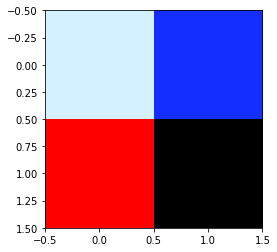

In [8]:
for fold in range(k_fold_value):
    
    if not trial:
        log_file = open("run_files/model_" + str(fold) + ".txt","w")
        model_output_name = "run_files/model_" + str(fold) + ".pth"
    
    piece_count = fold + 1
    
    # create train and valid files
    train,valid,piece_count = su.CV.get_K_fold_cv_data(smiles_label,k_fold_value,1,shuffle_output=True)
    
    su.write_cid_smiles_output(train,"train_file.txt")
    x_train,y_train = su.CNN.make_grid("train_file.txt",lensize,atomsize)
    
    su.write_cid_smiles_output(valid,"valid_file.txt")
    x_valid,y_valid = su.CNN.make_grid("valid_file.txt",lensize,atomsize)
    
    if fold == 0:
        su.write_cid_smiles_output(test_df,"test_file.txt")
        x_test,y_test = su.CNN.make_grid("test_file.txt",lensize,atomsize)

    
    # calculate class_weight
    if enable_class_weight:
        class_weight = torch.FloatTensor(su.get_class_weight(train)).cuda()
        if not trial:
            log_file.write("Class weight for loss (balancing weights)= " + str(class_weight) + "\n")
    
    if not trial:
        train_class_distriution = su.DNN.get_cluster_count_from_label([entry[0] for entry in y_train])
        valid_class_distriution = su.DNN.get_cluster_count_from_label([entry[0] for entry in y_valid])
        test_class_distriution = su.DNN.get_cluster_count_from_label([entry[0] for entry in y_test])
        log_file.write("Training : Class distribution = " + str(train_class_distriution) + "\n")
        log_file.write("Valid : Class distribution = " + str(valid_class_distriution) + "\n")
        log_file.write("Test : Class distribution = " + str(test_class_distriution) + "\n")
    
    
    train_loader = su.CV.get_dataloader(x_train,y_train.squeeze(),batchsize)
    valid_loader = su.CV.get_dataloader(x_valid,y_valid.squeeze(),batchsize)
    if fold == 0:
        test_loader = su.CV.get_dataloader(x_test,y_test.squeeze(),batchsize)
    
    
    model = Net(atomsize, lensize, k1, s1, f1, k2, s2, k3, s3, f3, k4, s4, n_hid, n_out)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if enable_class_weight:
        criterion = nn.CrossEntropyLoss(weight=class_weight)
    else:
        criterion = nn.CrossEntropyLoss()
    
    if not trial:
        log_file.write("Epochs = " + str(epochs) + "\n")
        log_file.write("Learning rate = " + str(learning_rate) + "\n")
        log_file.write("optimizer = " + str("Adam") + "\n")
        log_file.write("criterion = " + str("CrossEntropyLoss") + "\n")

    train_loss_list = []
    train_accu_list = []

    val_loss_list = []
    val_accu_list = []

    if not trial:
        log_file.write("Epoch\tLOSStrain\tLOSSval\tACCUtrain\tACCUval\n") 

    loop = tqdm.tqdm(range(epochs), total=epochs,leave=False)
    for epoch in loop:

        train_loss, train_accu = su.CNN.train(model,criterion,optimizer,train_loader,device)
        val_loss,val_accu = su.CNN.validate(model,criterion,valid_loader,device)
        
        if epoch == 0: # For callback
            torch.save(model.state_dict(), model_output_name)
            saved_model_id = epoch + 1
        else:
            current_epoch_values = [train_loss, train_accu,val_loss,val_accu]
            previous_epoch_values = [train_loss_list,train_accu_list,val_loss_list,val_accu_list]
            if su.callback(current_epoch_values,previous_epoch_values,model,model_output_name):
                saved_model_id = epoch + 1
        
        train_loss_list.append(train_loss)
        train_accu_list.append(train_accu)
        val_loss_list.append(val_loss)
        val_accu_list.append(val_accu)
        
        if not trial:
            log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
        loop.set_description("LOSS train:" + str(train_loss) + " val:" + str(val_loss) + " \tACCU train:" + str(train_accu) + " val:" + str(val_accu))
    
    
    model = Net(atomsize, lensize, k1, s1, f1, k2, s2, k3, s3, f3, k4, s4, n_hid, n_out)
    model.load_state_dict(torch.load(model_output_name), strict=True)
    model.to(device)

    if not trial: # classification report and confusion matrix plot
        loss,accuracy,prediction_list = su.CNN.test(model,criterion,train_loader,device)
        image_name = "run_files/train_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTrain data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Train data report \n-" + str(report) + "\n\n\n\n\n")
    
        loss,accuracy,prediction_list = su.CNN.test(model,criterion,valid_loader,device)
        image_name = "run_files/valid_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nValid data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Valid data report \n-" + str(report) + "\n\n\n\n\n")
        
        loss,accuracy,prediction_list = su.CNN.test(model,criterion,test_loader,device)
        image_name = "run_files/test_" + str(fold) + ".png"
        report = su.confustion_matrix(prediction_list,image_name)
        log_file.write("\n\n\nTest data : Accu-" + str(accuracy) + "\tLoss-" + str(loss) + "\n")
        log_file.write("Test data report \n-" + str(report) + "\n\n\n\n\n")
        
    log_file.close()
    
    if fold == 0 and not trial:
        network_parameter_output.write("model = " + str(model) + "\n")
        network_parameter_output.close()
        
    # best validation loss
    index = val_loss_list.index(sorted(val_loss_list)[0]) # index of least loss
    print ("Best model")
    print ("LOSS train:",train_loss_list[index]," val:",val_loss_list[index], "\tACCU train:",train_accu_list[index]," val:",val_accu_list[index])
    print ("Final model")    
    print ("LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)